# Determination of optimal operating point during ascent
This script computes the energy/force/power requirments for the ascent of a electrically-driven bike using a hub motor. Because the efficiency depends strongly on the rotational speed, low speed in ascent is not necessarily associated with a good energy management. The objective of the notebook is to estimate the opimal speed minimizing the overall energy use.

The model used here accounts for three energy sinks:
* The gravity force: $F_g=mg\sin\theta$, where $\theta$ is the inclination angle of the road, $m$ the mass of the rolling assembly and $g$ is the gravitational acceleration, assumed at 9.81 $ms^{-2}$
* The air friction force, assuming a turbulent regime: $F_f=\dfrac{1}{2}C_xA\rho v^2$. $C_x$ is the friction coeeficient associated to the shape, $A$ if the projected area normal to the velocity vector and $v$ is the velocity.
* The Joule dissipation in the wiring, transformed in an equivalent force: $F_e = \dfrac{1}{v}(\dfrac{P_{el,motor}}{U_{batt}})^2 R$. $P_{el,motor}$ designates the electric power consumed by the motor and $U_{batt}$ the voltage of the battery, and $R$ is the overall resistance of the electric circuit, which should includ the internal resistance of the batteries.

To get the energy needed, one would divide $F_g$ and $F_f$ by the efficiency $\eta(v)$ and add $F_e$ to it, and then integrate spatially over the route. Obsiously, reducing the energy by the distance leads back to the concept of force, as energy per unit distance.

Unless specified differently, the base case will work with the following parameters:
* Mass in motion : 90 kg
* Overall electrical resistance: 1 $\Omega$
* Road inclination: 5%
* Nominal battery voltage: 50V

In [13]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
from scipy import interpolate

mat = sio.loadmat('DataRendement')
a = mat['a']

U = 50 # Battery voltage (V)
R = 1 #Circuit resistance (Ohm)
m = 110 # Vehicle mass (kg)
FairCoeff = 0.5*(1 *1.2) #Coefficient of friction for turbulent regime

## Motor efficiency as a function of speed
The data recovered from the online motor simulation tool is recovered and displayed here. The motor is the All-Axle Hub Motor from Grin-Tech (https://www.ebikes.ca/product-info/all-axle-hub-motor.html) and the data comes from their motor simulator, based on the model 9C+2707 with 48V batteries.

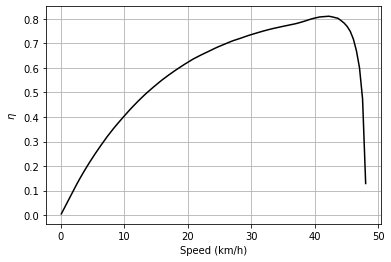

In [14]:
v = np.linspace(0.1,48,100)
f = interpolate.interp1d(a[:,0],a[:,1])
rend = f(v)/100

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(v,rend,'k')
plt.ylabel('$\eta$')
plt.xlabel('Speed (km/h)')
ax.grid(True)
plt.show()

## Energy demand computation

We are now ready to compute the energy needed per unit distance in different conditions. Because we want to remain general, a meaningful way to express the energy demand is to normalize the energy by the theoretical minimum energy necessary to progress on the slope. This energy is the potential energy from the difference of height, which would be reached by an ideal system without any form of losses: 100%-efficient motor, no electrical resistance, no air friction.

$\text{Normalized energy} = \dfrac{\text{Actual energy}}{\text{Potential energy}} = \dfrac{E}{mg\Delta h}$

The obtained energy will therefore tell of much many time more energy will would need for the bike, 1 being the ideal condition. Bear in mind that this normalization has a disadvantage, since it is not valid for flat road, since no theoretical energy is required to go along a flat path. In that case, the most economic speed is no speed at all!

### Influence of air friction

In the expression of the air friction force, the product $C_x A$ bears a large uncertainty, since it is difficult to estimate for a complex shape such as a bike. Therefore, we can assume a conservative estimate and then vary its value to adress its influence on the result. 

The following bloc of code computes the normalized energy as a function of speed for three cases: a medium friction case estimating $C_x= 0.5$ and $A=1$ $\text{m}^2$. A inclination of 5% is arbistrarily chosen for the road.

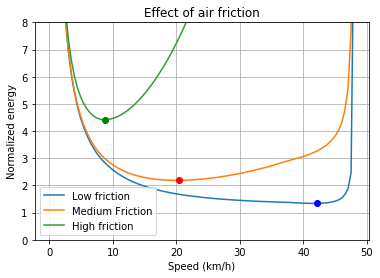

In [15]:
v = np.linspace(0.1,48,100)
f = interpolate.interp1d(a[:,0],a[:,1])
rend = f(v)/100

FairCoeff = 0.5*(1 *1.2)


def SpecificEnergy(slope,m,v,rend,FairCoeff,U,R):
    Fair = 0.8*FairCoeff*np.power(v/3.6,2)
    Fg  = m*9.81*np.sin(np.arctan(slope))
    Ed = (Fair+Fg)/rend
    I = Ed * (v/3.6) /U
    Pel = R*np.power(I,2)
    Ed1 = Ed+Pel/v
    return Ed1/(m*9.81*np.sin(np.arctan(slope)))

Ed1 = SpecificEnergy(0.05,m,v,rend,FairCoeff*0,U,R)
Ed2 = SpecificEnergy(0.05,m,v,rend,FairCoeff,U,R)
Ed3 = SpecificEnergy(0.05,m,v,rend,FairCoeff*10,U,R)

minED1 = np.argmin(Ed1)
minED2 = np.argmin(Ed2)
minED3 = np.argmin(Ed3)

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(v,Ed1,label='Low friction')
plt.plot(v[minED1],Ed1[minED1],'bo')
plt.plot(v,Ed2,label='Medium Friction')
plt.plot(v[minED2],Ed2[minED2],'ro')
plt.plot(v,Ed3,label='High friction')
plt.plot(v[minED3],Ed3[minED3],'go')
plt.ylim(0,8)
plt.ylabel('Normalized energy')
plt.xlabel('Speed (km/h)')
plt.title('Effect of air friction')
ax.legend(loc='lower left')
ax.grid(True)
plt.show()



The larger the air friction, the smaller the speed minimizing the energy, since the importance of the motor inefficiency is reduced compared to this other type of loss. With no friction, the best point is the one close to the point of maximum motor efficiency. For the medium case, a speed of approximately 20 km/h appears the most economic one. However, deviating from this exact speed is no big deal since the curvature is locally small: going at 15 or 25 km/h will barely affect the energy demand.

### Influence of slope
The second aspect regard the inclination of the road. How does the optimal speed evolves with a increasingly steep road? The same normalized energy computation is performed here with 1, 5 and 12% inclination.

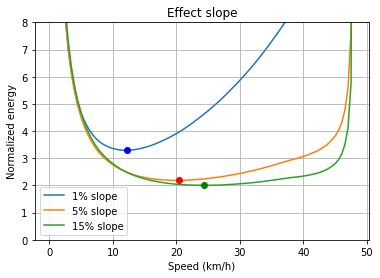

In [16]:
Ed1 = SpecificEnergy(0.01,m,v,rend,FairCoeff,U,R)
Ed2 = SpecificEnergy(0.05,m,v,rend,FairCoeff,U,R)
Ed3 = SpecificEnergy(0.12,m,v,rend,FairCoeff,U,R)

minED1 = np.argmin(Ed1)
minED2 = np.argmin(Ed2)
minED3 = np.argmin(Ed3)

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(v,Ed1,label='1% slope')
plt.plot(v[minED1],Ed1[minED1],'bo')
plt.plot(v,Ed2,label='5% slope')
plt.plot(v[minED2],Ed2[minED2],'ro')
plt.plot(v,Ed3,label='15% slope')
plt.plot(v[minED3],Ed3[minED3],'go')
plt.ylim(0,8)
plt.ylabel('Normalized energy')
plt.xlabel('Speed (km/h)')
plt.title('Effect slope')
ax.legend(loc='lower left')
ax.grid(True)
plt.show()

Interestingly enough, a strong slope encourages a higher speed, as the aerodynamic force is increasingly dominated by the gravitational force, magnifying the relative importance of the motor efficiency. Therefore, the steeper the road, the faster one should drive in order to minimize the energy demand. This can be very surprising at first sight, but makes sense in the end.

### Influence of overall electric resistance
Another parameter bearing a large uncertainty is the overall circuit resistance used to compute the Joule losses due to the current flowing across the system. In first assumption, a resistance of 1$\Omega$ was chosen. Here, this value is varied by a factor 10 in both direction to grasp its influence on the optimal speed.  

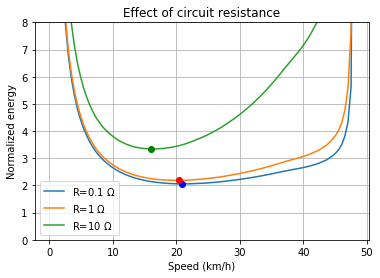

In [17]:
Ed1 = SpecificEnergy(0.05,m,v,rend,FairCoeff,U,0.1)
Ed2 = SpecificEnergy(0.05,m,v,rend,FairCoeff,U,1)
Ed3 = SpecificEnergy(0.05,m,v,rend,FairCoeff,U,10)

minED1 = np.argmin(Ed1)
minED2 = np.argmin(Ed2)
minED3 = np.argmin(Ed3)

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(v,Ed1,label='R=0.1 $\Omega$')
plt.plot(v[minED1],Ed1[minED1],'bo')
plt.plot(v,Ed2,label='R=1 $\Omega$')
plt.plot(v[minED2],Ed2[minED2],'ro')
plt.plot(v,Ed3,label='R=10 $\Omega$')
plt.plot(v[minED3],Ed3[minED3],'go')
plt.ylim(0,8)
plt.ylabel('Normalized energy')
plt.xlabel('Speed (km/h)')
plt.title('Effect of circuit resistance')
ax.legend(loc='lower left')
ax.grid(True)
plt.show()

There is a negligible difference between 0.1 and the nominal case 1$\Omega$, with the same optimal speed as before, in the vicinity of 20 km/h. Howver, a resistance of 10$\Omega$ reduces significantly the optimal speed, since a lower speed will slightly reduce the electric current flowing in the circuit. 

## Conclusion
The main point of this short study is to show that when it comes to going uphill with a hub motor, one should go at a relatively large speed in order to minimize the overall energy consumption. One should not go slowly thinking it will be energetically advantageous. Because the gear ratio between the wheel and the motor is fixed, the motor efficiency will be significantly affected at low speed and will increase the overall energy need. At higher speed however, the total energy needed is comparatively reduced, although the electric power drawn from the battery will be higher. For the simplified model considered here, a speed between 17 and 20 km/h seems to be a reasonable speed when trying to minimize the energy needs. Very aerodynamic bikes might even benefit from larger speeds.